### DDI Corpus 2013 Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.corpus import stopwords

In [2]:
colnames = ['ddi_id', 'text', 'ddi_type']
data = pd.read_csv('./ddi_train_grouped_sentences.csv', header = None, names = colnames)

In [3]:
data.head()

,ddi_id,text,ddi_type
0,DDI-DrugBank.d519.s3,laboratory tests response to plenaxis should b...,false
1,DDI-DrugBank.d297.s1,population pharmacokinetic analyses revealed t...,false
2,DDI-DrugBank.d297.s2,the majority of patients in ra clinical studie...,false
3,DDI-DrugBank.d297.s3,concurrent administration of a tnf antagonist ...,effect
4,DDI-DrugBank.d297.s4,concurrent therapy with orencia and tnf antago...,advise


In [34]:
data['word_count'] = data['text'].str.split().apply(len)
data.groupby('ddi_type').mean()

,word_count
ddi_type,
advise,22.545263
effect,21.738407
false,21.548235
int,22.370370
mechanism,24.037685


In [35]:
data.groupby('ddi_type').count()['ddi_id']

ddi_type
advise        475
effect        841
false        1700
int            54
mechanism     743
Name: ddi_id, dtype: int64

C:\Users\JasonL\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


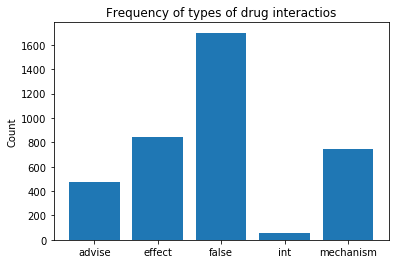

In [5]:
freqs = data.groupby('ddi_type').count()['ddi_id'].tolist()
indices = np.arange(len(freqs))
width = 0.25
fig, ax = plt.subplots(ncols = 1)
bars = ax.bar(indices, freqs)
ax.set_ylabel('Count')
ax.set_title('Frequency of types of drug interactios')
ax.set_xticks(indices)
ax.set_xticklabels(['advise', 'effect', 'false', 'int', 'mechanism'])
ax.legend()
plt.show()

From the bar chart, there seems to be a small amount of sentences that simply state an interaction occurs without givine more information (the `int` column). Taking the interactions all together, there does not seem to be an under-representation of sentences that describe interactions versus senetneces that do not describe interactions. 

#### Most frequent words (excluding common stop words)

In [12]:
false_ddis = data[data['ddi_type'] == 'false']
true_ddis = data[data['ddi_type'] != 'false']

In [16]:
def get_word_frequencies(data):
    '''returns a dictionary with the word as a key and frequency in the dataset as a value'''
    table = str.maketrans("", "", string.punctuation)
    word_frequencies = {}
    stop_words = set(stopwords.words('english'))
    for i in range(len(data)):
        words = data.iloc[i]['text'].translate(table).split()
        for word in words:
            if word not in stop_words:
                if word_frequencies.get(word.strip(), 0) == 0:
                    word_frequencies[word.strip()] = 0
                word_frequencies[word.strip()] += 1
    return word_frequencies

In [22]:
false_ddi_word_frequencies = get_word_frequencies(false_ddis)
true_ddi_word_frequencies = get_word_frequencies(true_ddis)

In [25]:
false_ddi_word_frequencies_df = pd.DataFrame.from_dict(false_ddi_word_frequencies, orient = 'index')
top_20_false = false_ddi_word_frequencies_df.loc[:,0].sort_values(ascending = False)[:20]
true_ddi_word_frequencies_df = pd.DataFrame.from_dict(true_ddi_word_frequencies, orient = 'index')
top_20_true = true_ddi_word_frequencies_df.loc[:,0].sort_values(ascending = False)[:20]

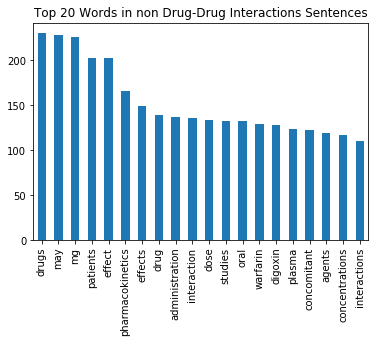

In [30]:
ax = top_20_false.plot(kind = 'bar', title = 'Top 20 Words in non Drug-Drug Interactions Sentences')
plt.show()

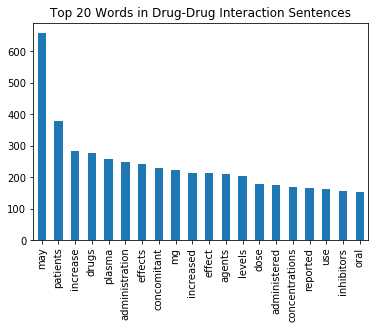

In [31]:
ax = top_20_true.plot(kind = 'bar', title = 'Top 20 Words in Drug-Drug Interaction Sentences')
plt.show()

The word 'may' seems to occur a lot more in sentences that describe drug-drug interactions. One possible reason for this is that sentences that describe drug-drug interactions are based on evidence that suggests the presece of a drug-drug interaction. It is more likely that a sentence such as 'drug_x may interact with drug_y' than a sentence like 'drug_x may not interact with drug_y' because usually drug pairs that do not result in interactions are more absolute and do not need the operator word 'may'.

#### Frequency of Negative Bigrams

We explore the frequency of negative bigram phrases -- two word phrases that begin with the word 'no' or 'not' between texts that do and do not describe drug-drug interactions. It is often the case that sentences that do not describe drug-drug interactions have negative phrases such as 'no clinically significant effect', 'not apparent', 'not clinically significant', etc.

In [39]:
def get_negative_bigram_frequencies(data):
    '''returns a dictionary with the bigram as a key and frequency in the dataset as a value'''
    table = str.maketrans("", "", string.punctuation)
    word_frequencies = {}
    for i in range(len(data)):
        words = data.iloc[i]['text'].translate(table).split()
        for i in range(len(words) - 1):
            if words[i].strip() == 'no' or words[i].strip() == 'not':
                bigram = " ".join([words[i].strip(), words[i+1].strip()])
                if word_frequencies.get(bigram, 0) == 0:
                    word_frequencies[bigram] = 0
                word_frequencies[bigram] += 1
    return word_frequencies

In [42]:
false_ddi_negative_bigrams = get_negative_bigram_frequencies(false_ddis)
true_ddi_negative_bigrams = get_negative_bigram_frequencies(true_ddis)

In [44]:
false_ddi_negative_bigrams_df = pd.DataFrame.from_dict(false_ddi_negative_bigrams, orient = 'index')
top_20_false_bigrams = false_ddi_negative_bigrams_df.loc[:,0].sort_values(ascending = False)[:20]
true_ddi_negative_bigrams_df = pd.DataFrame.from_dict(true_ddi_negative_bigrams, orient = 'index')
top_20_true_bigrams = true_ddi_negative_bigrams_df.loc[:,0].sort_values(ascending = False)[:20]

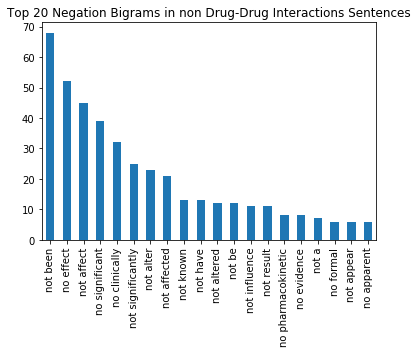

In [46]:
ax = top_20_false_bigrams.plot(kind = 'bar', title = 'Top 20 Negation Bigrams in non Drug-Drug Interactions Sentences')
plt.show()

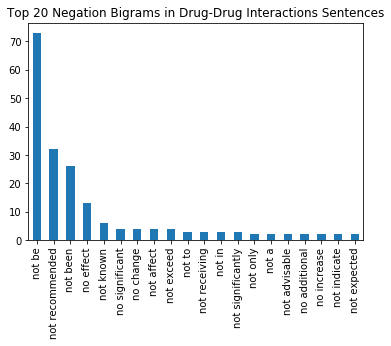

In [47]:
ax = top_20_true_bigrams.plot(kind = 'bar', title = 'Top 20 Negation Bigrams in Drug-Drug Interactions Sentences')
plt.show()

Overall, negation phrases seem to be more frequent in sentences that do not describe drug-drug interactions. It is interesting to note that the phrase 'not recommended' appears fairly frequently in sentences that describe drug-drug interactions compared to sentences that do. Because it appears that negative phrases may have some predictive power over whether a sentence is a drug-drug interaction or not, it might be helpful to consider keeping commonly negative stopwords like 'no' or 'not' instead of removing them in pre-processing.